# Lab session of 23/03/2022

## Graph problem 2: Minimum Spanning Tree, cutset formulation

Write and solve the cut-set formulation of the Minimum Spanning Tree (MST) for a random graph.

## Solution

A formulation of the MST problem uses *cut sets*: given a graph $G=(V,E)$ with $V$ the set of nodes and $E$ the set of edges, we create binary variables $x_{ij}$ for each $(i,j)\in E$ such that $x_{ij}$ is 1 if $(i,j)$ is in the solution, 0 otherwise. Then the formulation includes $cut set$ inequalities.

A *cut* $\delta(S)$ in a graph $G=(V,E)$ is a subset of edges generated by a subset of nodes $S\subset V$: an edge $(i,j)\in E$ is in $\delta(S)$ if exactly one among $i$ and $j$ is in $S$.


The formulation enforces the following condition:

__For any cut $\delta(S)$ containing the set of edges $(i,j)$ with $i$ in $S\subset V$ and $j$ in $V\setminus S$, there must be at least one edge of $\delta(S)$ in the solution.__

This implies that a formulation for the MST is 

$$
\begin{array}{lll}
  \min & \sum_{(i,j)\in E} c_{ij} x_{ij}\\
  \textrm{s.t.} & \sum_{(i,j)\in \mathcal \delta(S)} x_{ij} \ge 1 & \forall S\subset V:S\neq \emptyset\\
                & x_{ij} \in \{0,1\} & \forall (i,j)\in E
\end{array}
$$

Write the above formulation and solve it for a random graph.

In [1]:
# When using Colab, make sure you run this instruction beforehand
!pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
!pip install mip

In [2]:
# Spanning tree problem. Using the cutset formulation.
# Finding a tree in the graph that covers every node at a minimal cost.
# Take a graph with a set of nodes and a set of edges and only pick some edges in such a way that 
# 1) We create a tree
# 2) pick a tree with the minimal cost;
# 3) We must touch every node in the graph.

# Trying to solve this with the cutset formulation. 
# We introduce a binary variable x_ij for every arc in our graph. (edge).
# Either we pick that edge = 1. Either we leave it out from the solutio = 0.

# The constraints : We need to cover each node. If we divide the graph in two. We have a node that is related to another one 
# There is at least on arc that goes from the first part to the second part. Otherwise, our graph we'll saty disconnected.

# delta(S) means one side is in the side of S and the other side is in the rest of the nodes.
# For each cut, there is at least one edge that goes from one edge to the rest of the nodes.
# So when we separate the nodes, we must always have at least an arc connecting the two parts.


# Steps: Generate a graph.
# Run the model. 
# Visualize the solution.

import numpy as np
import math

k = 10
grid_size = 100 # size of the grid of points

# distance beyond which we don't want edges
d_max = .47 * grid_size

np.random.seed(12345)

# Create k random points with two coordinates. Multiplying by grid_size yields
# random numbers between 0 and 100.

#point = grid_size * np.random.random((k,2))

point = np.array([[38.62750686343595, 62.850117953971164],
            [12.505792633559942, 98.35486051436412],
            [44.32248686451281, 78.95583420239032],
            [79.41185757915866, 36.12615724174307],
            [41.6103939570998, 58.42581281103214],
            [76.01717738058575, 18.780840542641563],
            [28.81671478120357, 67.02188581602341],
            [49.96482613720124, 17.85686771635271],
            [41.314130142465885, 19.91952352050984],
            [53.16994035870367, 83.23707030679826]])

# Define the set of vertices of the graph as the list of numbers from 0 to k-1

V = [i for i in range(k)]

# Determine the distance between each point

distance = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])
print(distance)

# Set of edges: note the condition that i<j (so we have pairs i,j but not j,i)
# and especially the condition that prevents long arcs.

# Ususally, in the litterature, we find a capital E related to the undirected edges.

E = [(i,j) for i in V for j in V if i < j and distance[i,j] <= d_max]


[[  0.          44.07868758  17.08294158  48.75995631   5.33592461
   57.79350027  10.66092343  46.39964844  43.01457756  25.0421684 ]
 [ 44.07868758   0.          37.264249    91.37194885  49.41059268
  101.8121832   35.32423368  88.78685734  83.55849687  43.38341262]
 [ 17.08294158  37.264249     0.          55.36826858  20.70838541
   68.01164069  19.56650434  61.35894147  59.11291051   9.82885629]
 [ 48.75995631  91.37194885  55.36826858   0.          43.8887832
   17.67438443  59.28249758  34.65392619  41.40159191  53.92658296]
 [  5.33592461  49.41059268  20.70838541  43.8887832    0.
   52.49333836  15.41332858  41.42023471  38.50742899  27.37191282]
 [ 57.79350027 101.8121832   68.01164069  17.67438443  52.49333836
    0.          67.49134847  26.06873091  34.72172355  68.38568414]
 [ 10.66092343  35.32423368  19.56650434  59.28249758  15.41332858
   67.49134847   0.          53.5204785   48.73210363  29.2576794 ]
 [ 46.39964844  88.78685734  61.35894147  34.65392619  41.420234

Below is code for generating all subsets of a given list of objects. We will use `powerset` to create all constraints of the formulation.

In [3]:
# Generate the powerset of V
# Contains all the subset of V
from itertools import chain, combinations
powerset = list(chain.from_iterable(combinations(V, r) for r in V))

# combinations(V,1) = (0,), (1,),... (k-1), and so on...
# f.i. powerset = [(0,), (1,)..., (0,1), ..., (0,1,2)] Until we consider all the subsets of V

We have all we need to write the problem.

In [4]:
# We need to write the model.
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in E}

for S in powerset:
    # We can only include subsets that are note empty.
    # Also, we don't want to include the set of all nodes.
    if len(S) > 0 and len(S) < k:
        m.add_constr(mip.xsum(x[i,j] for (i,j) in E 
                            if (i in S and j not in S)
                            or (j in S and i not in S)) >= 1)

m.objective = mip.minimize(mip.xsum(distance[i,j]*x[i,j] for (i,j) in E))
%time m.optimize()

sol = [(i,j) for (i,j) in E if x[i,j].x > 0.0001]
print(f"{len(sol)} slected. {sol}")

# We need to visualize it.

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 28 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 511 (-511) rows, 25 (0) columns and 6400 (-6400) elements
Clp1000I sum of infeasibilities 2.30243e-05 - average 4.50574e-08, 0 fixed columns
Coin0506I Presolve 511 (0) rows, 25 (0) columns and 6400 (0) elements
Clp0029I End of values pass after 25 iterations
Clp0014I Perturbing problem by 0.001% of 1.0000002 - largest nonzero change 2.9822462e-05 ( 0.0014911231%) - largest zero change 2.5215374e-05
Clp0000I Optimal - objective value 129.72275
Clp0000I Optimal - objective value 129.72275
Clp0000I Optimal - objective value 129.72275
Coin0511I After Postsolve, objective 129.72275, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 129.7227461 - 0 iterations time 0.082, Presolve 0.00, Idiot 0.07

Starting MIP optimization
CPU times: user 206 ms, sys: 29.6 ms, total: 236 ms
Wall time: 262 ms
9 slec

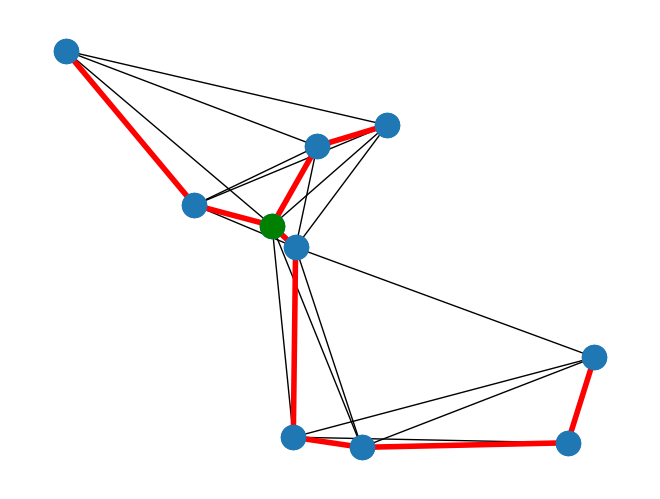

In [5]:
# Same method as before
import networkx as nx

def draw_solution(V, A, x):
    g = nx.Graph()

    # Draw the whole graph first: all nodes, all arcs, no highlighting
    g.add_nodes_from(V)
    g.add_edges_from([(i,j) for (i,j) in A])
    nx.draw(g, pos=point)

    # Reset the graph and add only the arcs that belong to the solution, 
    # i.e. those for which the optimal value of the variable f[i,j] is nonzero
    g.clear()
    g.add_edges_from([(i,j) for (i,j) in A if x[i,j].x > 0.001])
    nx.draw(g, pos=point, width=4, edge_color='red')

    # finally, draw a graph consisting of the sole root node, highlighted in green
    g.clear()
    g.add_node(0)
    nx.draw(g, pos={0: point[0]}, node_color='green')
    
# after defining the function, call it with the current data
draw_solution (V, E, x)

# We can see that we have 11 nodes and 10 arcs connecting each nodes.
# The green source is irrelevant because we just wanted the method of the spanning tree.
# We just copied from the last exercise. 


# In computing science in general,
# For technical reasons an x[i,j] for us is zero however, for the computer it might be 0.0000000001.
# Every time we compare two floating numbers, always use a threshold on the difference.



In [6]:
point = np.array([[38.62750686343595, 62.850117953971164],
            [12.505792633559942, 98.35486051436412],
            [44.32248686451281, 78.95583420239032],
            [79.41185757915866, 36.12615724174307],
            [41.6103939570998, 58.42581281103214],
            [76.01717738058575, 18.780840542641563],
            [28.81671478120357, 67.02188581602341],
            [49.96482613720124, 17.85686771635271],
            [41.314130142465885, 19.91952352050984],
            [53.16994035870367, 83.23707030679826]])

In [12]:
import matplotlib.pyplot as plt

def recalculate_clusters(X, centroids, k):
    """ Recalculates the clusters """
    # Initiate empty clusters
    clusters = {}
    # Set the range for value of k (number of centroids)
    for i in range(k):
        clusters[i] = []
    # Setting the plot points using dataframe (X) and the vector norm (magnitude/length)
    for data in X:
        # Set up list of euclidian distance and iterate through
        euc_dist = []
        for j in range(k):
            euc_dist.append(np.linalg.norm(data - centroids[j]))
        # Append the cluster of data to the dictionary
        clusters[euc_dist.index(min(euc_dist))].append(data)
    return clusters    
 
def recalculate_centroids(centroids, clusters, k):
    """ Recalculates the centroid position based on the plot """ 
    for i in range(k):
        # Finds the average of the cluster at given index
        centroids[i] = np.average(clusters[i], axis=0)
    return centroids

def plot_clusters(centroids, clusters, k):
    """ Plots the clusters with centroid and specified graph attributes """ 
    colors = ['red', 'blue' , 'green', 'orange', 'blue', 'gray', 'yellow', 'purple']
    plt.figure(figsize = (6, 4))  
    area = (20) ** 2
    for i in range(k):
        for cluster in clusters[i]:
            plt.scatter(cluster[0], cluster[1], c=colors[i % k], alpha=0.6)    
        plt.scatter(centroids[i][0], centroids[i][1], c='black', s=200)

def k_means_clustering(X, centroids={}, k=3, repeats=100):
    """ Calculates full k_means_clustering algorithm """
    for i in range(k):
        # Sets up the centroids based on the data
        centroids[i] = X[i]

    # Outputs the recalculated clusters and centroids 
    print(f'First and last of {repeats} iterations')
    for i in range(repeats):        
        clusters = recalculate_clusters(X, centroids, k)  
        centroids = recalculate_centroids(centroids, clusters, k)

        # Plot the first and last iteration of k_means given the repeats specified
        # Default is 10, so this would output the 1st iteration and the 10th
        if i == range(repeats)[-1] or i == range(repeats)[0]:
            plot_clusters(centroids, clusters, k)
    return clusters

First and last of 100 iterations


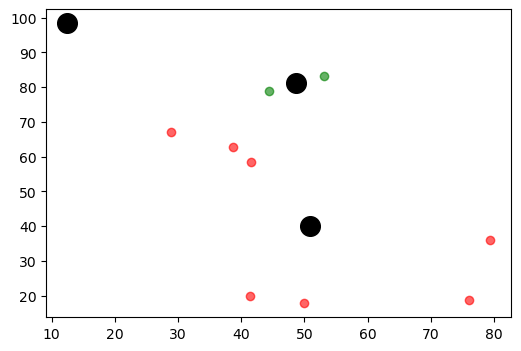

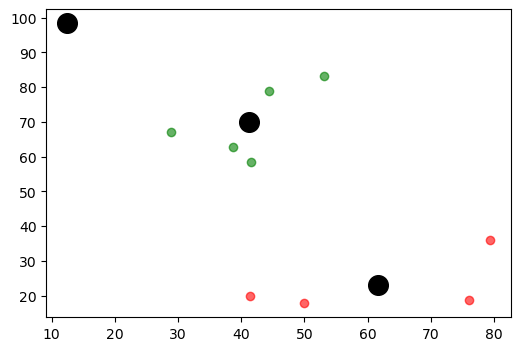

In [15]:
clusters = k_means_clustering(point, k = 3)
a = {}
for i in clusters:
    b = np.zeros((len(clusters[i]),2))
    for j in range(len(clusters[i])):
        b[j] = clusters[i][j]
    a[i] = b
clusters = a # This version of clusters is ready for the spanning tree
# spanning_tree(clusters[0])
# spanning_tree(clusters[1])
# ...

In [179]:
a = [1,2,3]

[1, 2, 3, [2, 3, 4]]
